
# Parameter Estimation for a Gaussian Distribution

## Introduction
This chapter illustrates the uses of parameter estimation in generating Gaussian distribution for a set of measurement, and investigates how the change of parameters ($\mu,\sigma$) will change the pdf result. 
Moreover, we will compare the posterior parameter estimation with other estimation methods, such as Gaussian distribution and bootstrap estimation.   
See *"Statistics, Data Mining, and Machine Learning in Astronomy:
A Practical Python Guide for the Analysis of Survey Data"* Chapter 5.6.1 for reference. 

## Import Data and Functions

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from astroML.plotting.mcmc import convert_to_stdev

from astroML.resample import bootstrap

from scipy.stats import norm, anderson
from astroML.stats import mean_sigma, median_sigmaG

## Log-likelihood for Gaussian Distribution
Suppose we have N measurements, ${x_i}$. The measurement errors are Gaussian, and the measurement error for each
measurement is $\sigma_i$ (heteroscedastic errors). This method applies logrithm in searching the posterior probability density function (pdf) as $\mu: p(\mu|{x_i},{\sigma_i})$.  
Given that the likelihood function for a single measurement, $x_i$, is assumed to follow a Gaussian
distribution $\mathcal{N}(\mu,\sigma)$, the likelihood for all measurements is given by
$p({x_i}|\mu,\sigma,I) = \prod_{i=1}^N \frac{1}{\sqrt{2\pi} \sigma} exp(\frac{-(x_i-\mu)^2)}{2\sigma^2})$
Here we have $\sigma$ to be estimated.

Adopting a uniform prior distribution for the location parameter $\mu$ and a uniform prior distribution for $ln\sigma$, we have
$p(\mu,\sigma|I)\propto \large{\frac{1}{\sigma}}$, for $\mu_{min}\leq \mu \leq \mu_{max}$ 
and $\sigma_{min} \leq \sigma \leq \sigma_{max}$.
  
And the logarithm of the posterior pdf is 
$$L_p = constant - (N+1)ln\sigma - \frac{N}{2\sigma^2}((\bar{x}-\mu)^2 + V)$$

where N is the sample size, and V is defined as 
$V = \normalsize{N^{-1}\sum_{i=1}^N(x_i - \bar{x})^2} = \large{\frac{(N-1)s^2}{N}}$,  

in which s is the sample standard deviation from equation $s=\normalsize{\sqrt{\frac{1}{N-1}\sum_{i=1}^{N}(x_i-\bar{x})^2}}$,  
and $\bar{x}$ is the sample arithmetic mean from $\normalsize{x_i = \frac{1}{N}\sum_{i=1}^{N}x_i}$.

### 1. Define function
First we define function to calculate Log-likelihood Gaussian distribution. Taking $\bar{x}, V, n, \sigma, \mu$ as parameters.  
In this example, we have N = 10, $\bar{x}$ = 1, and V = 4. The maximum of $L_p$ is renormalized to 0.

In [ ]:
# Define the function for calculating log-likelihood Gaussian distribution
def gauss_logL(xbar, V, n, sigma, mu):
    """Gaussian likelihood"""
    return (-(n + 1) * np.log(sigma)
            - 0.5 * n * ((xbar - mu) ** 2 + V) / sigma ** 2)

# Define the grid and compute logL
sigma = np.linspace(1, 5, 70)
mu = np.linspace(-3, 5, 70)
xbar = 1
V = 4
n = 10

logL = gauss_logL(xbar, V, n, sigma[:, np.newaxis], mu)
logL -= logL.max()

### 2. Generate Distribution diagram
Next, we draw a Gaussian distribution using the logarithm of the posterior probability density finction for  $\mu$ and $\sigma$, $L_p(\mu,\sigma)$ in the equation described above.  
In this example, the maximum value of $L_p$ is at $\mu_0 = 1.0$ and $\sigma_0 = 1.8$. Color code for the density is shown in the legend. The contours enclose the regions that contain 0.683, 0.955, and 0.997 of the cumulative (integrated) posterior probability.

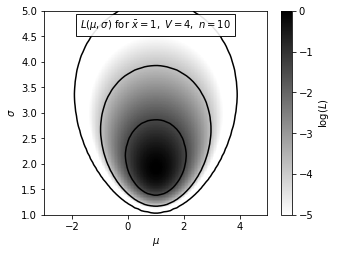

In [ ]:
fig = plt.figure(figsize=(5, 3.75))
plt.imshow(logL, origin='lower',
           extent=(mu[0], mu[-1], sigma[0], sigma[-1]),
           cmap=plt.cm.binary,
           aspect='auto')
plt.colorbar().set_label(r'$\log(L)$')
plt.clim(-5, 0)

plt.contour(mu, sigma, convert_to_stdev(logL),
            levels=(0.683, 0.955, 0.997),
            colors='k')

plt.text(0.5, 0.93, r'$L(\mu,\sigma)\ \mathrm{for}\ \bar{x}=1,\ V=4,\ n=10$',
         bbox=dict(ec='k', fc='w', alpha=0.9),
         ha='center', va='center', transform=plt.gca().transAxes)

plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')

plt.show()

## Posterior for Gaussian Distribution
1. We calculate the result from the **posterior probability density function** $p(\mu|{x_i},I)$ using equation

$$p(\mu|{x_i},I)\propto[1+\frac{(\bar{x}-\mu)^2}{V}]^{\frac{-N}{2}}$$

with respect to $\mu$ (integral over $\sigma$ for the two-dimensional distribution shown in figure in the above section) when taking uniform prior of $\sigma$ and prior of $\sigma$ that is propotional to $\sigma^{-1}$.  
We compare this result with **Gaussian distribution** calculated using parameters $\bar{x}$ and $\sigma_{\bar{x}}$ from

$$\normalsize{\bar{x} = \frac{1}{N}\sum_{i=1}^{N}x_i}$$
$$\sigma_{\bar{x}}=\frac{s}{\sqrt{N}}$$

we as well compare it with the mean given by the equation above using **bootstrap estimation**.  

2. Also we calculate the result from the **posterior probability density function** $p(\sigma|{x_i},I)$ by

$$p(\sigma|{x_i},I)\propto \frac{1}{\sigma^N}exp(\frac{-NV}{2\sigma^2})$$ 

with respect to $\sigma$ (integral over $\mu$ for the two-dimensional distribution shown in figure in the above section) when taking uniform prior of $\sigma$ and prior of $\sigma$ that is propotional to $\sigma^{-1}$.  
We compare this result with **Gaussian distribution** calculated using parameters $s$ and $\sigma_{s}$ from

$$s=\sqrt{\frac{1}{N-1}\sum_{i=1}^{N}(x_i-\bar{x})^2}$$ 
$$\sigma_s = \frac{s}{\sqrt{2(N-1)}} = \frac{1}{\sqrt{2}}\sqrt{\frac{N}{N-1}}\sigma_{\bar{x}}$$

we as well compare it with the mean given by the equation above using **bootstrap estimation**. 
  
3. The result of probability distribution and a cululative distribution will be displayed.  

### 1. Define functions for computations
These are expected analytic fits to the posterior distributions. The functions defined below follows the equation above.

In [ ]:
def compute_pmu(mu, xbar, V, n):
    return (1 + (xbar - mu) ** 2 / V) ** (-0.5 * n)

def compute_pmu_alt(mu, xbar, V, n):
    return (1 + (xbar - mu) ** 2 / V) ** (-0.5 * (n - 1))

def compute_psig(sig, V, n):
    return (sig ** -n) * np.exp(-0.5 * n * V / sig ** 2)

def compute_psig_alt(sig, V, n):
    return (sig ** -(n - 1)) * np.exp(-0.5 * n * V / sig ** 2)

def gaussian(x, mu, sigma):
    return np.exp(-0.5 * (x - mu) ** 2 / sigma ** 2)

Equivalently, we can instead use function (sciypy.stats.norm) in Scipy package to draw a gaussian distribution from sample. See [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html) for reference. Examples are shown below.

In [ ]:
# draw normal gaussian function
# scipy.stats.norm(mean, std) 

# probability density function 
# norm.pdf(x, loc, scale)

from scipy import stats
dist = stats.norm (0, 1) # mean = 0, stdev = 1
r = dist.rvs (10) # ten random draws
p = dist.pdf (0) # pdf evaluated at x=0

Alternatively, in Python 3.8 we have function NormalDist in statistics, which takes $\mu$ and $\sigma$ as arguments. 
See [documentation](https://docs.python.org/3.8/library/statistics.html?highlight=normaldist#statistics.NormalDist) for more information. Example is shown below.

In [ ]:
# from statistics import NormalDist
# NormalDist(mu=100, sigma=10).pdf(x)

### 2. Computation
Draw a random sample from the distribution, and compute some quantities. Here we take the posterior probability density functions $p(\mu|\{x_i\},I)$ and $p(\sigma|\{x_i\},I)$ with N = 10, x = 1 and V = 4 parameters.

In [ ]:
n = 10
xbar = 1
V = 4
sigma_x = np.sqrt(V)

np.random.seed(10)
xi = np.random.normal(xbar, sigma_x, size=n)

mu_mean, sig_mean = mean_sigma(xi, ddof=1)

# compute the analytically expected spread in measurements
mu_std = sig_mean / np.sqrt(n)
sig_std = sig_mean / np.sqrt(2 * (n - 1))

# bootstrap estimates
mu_bootstrap, sig_bootstrap = bootstrap(xi, int(1E6), mean_sigma,
                                        kwargs=dict(ddof=1, axis=1))

# Compute analytic posteriors

# distributions for the mean
mu = np.linspace(-3, 5, 1000)
dmu = mu[1] - mu[0]

pmu = compute_pmu(mu, 1, 4, 10)
pmu /= (dmu * pmu.sum())

pmu2 = compute_pmu_alt(mu, 1, 4, 10)
pmu2 /= (dmu * pmu2.sum())

pmu_norm = gaussian(mu, mu_mean, mu_std)
pmu_norm /= (dmu * pmu_norm.sum())

mu_hist, mu_bins = np.histogram(mu_bootstrap, 20)
mu_dbin = np.diff(mu_bins).astype(float)
mu_hist = mu_hist / mu_dbin / mu_hist.sum()

# distributions for the standard deviation
sig = np.linspace(1E-4, 8, 1000)
dsig = sig[1] - sig[0]
psig = compute_psig(sig, 4, 10)
psig /= (dsig * psig.sum())

psig2 = compute_psig_alt(sig, 4, 10)
psig2 /= (dsig * psig2.sum())

psig_norm = gaussian(sig, sig_mean, sig_std)
psig_norm /= (dsig * psig_norm.sum())

sig_hist, sig_bins = np.histogram(sig_bootstrap, 20)
sig_dbin = np.diff(sig_bins).astype(float)
sig_hist = sig_hist / sig_dbin / sig_hist.sum()

### 3. Generate diagram of methods
The top two diagrams show how the estimated probability density change with the variations of $\sigma$ and $\mu$ parameters, with a comparison of Gaussian distribution and bootstrap estimation of mean value.  
  
* The solid lines represent the posterior pdf with prior of $\sigma$ proportional to $\sigma^{-1}$.  
* The dotted lines represent the same pdf with uniform prior of $\sigma$.  
* The dashed lines represent Gaussian distribution with parameters calculated using equations given above.  
* The circles represent the bootstrap estimated distribution of mean.  
  
The bottom two diagrams show the percentage confidence from the above methods. The dotted line shows an equivalent result when the prior for $\sigma$ is uniform and is proportional.   

Text(0, 0.5, '$P(<\\sigma|x,I)$')

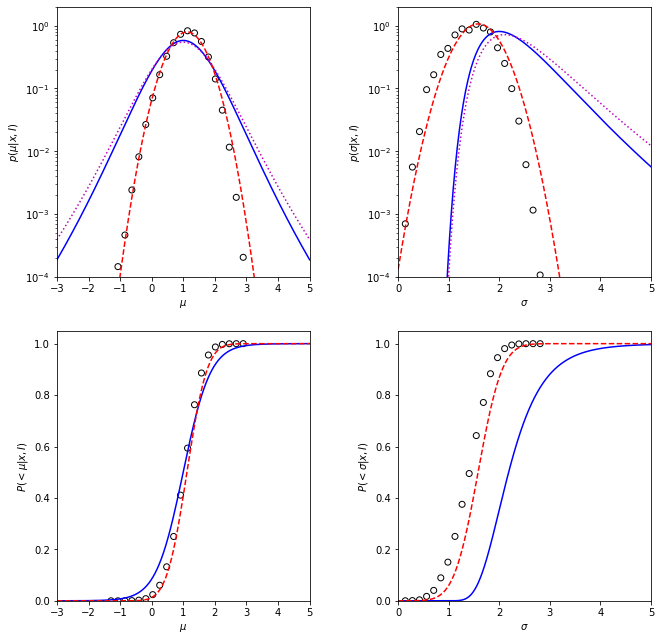

In [ ]:
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(wspace=0.35, right=0.95,
                    hspace=0.2, top=0.95)

# plot posteriors for mu
ax1 = plt.subplot(221, yscale='log')
ax1.plot(mu, pmu, '-b')
ax1.plot(mu, pmu2, ':m')
ax1.plot(mu, pmu_norm, '--r')
ax1.scatter(mu_bins[1:] - 0.5 * mu_dbin, mu_hist,
            edgecolor='k', facecolor='none')

ax1.set_xlabel(r'$\mu$')
ax1.set_ylabel(r'$p(\mu|x,I)$')

ax2 = plt.subplot(223, sharex=ax1)
ax2.plot(mu, pmu.cumsum() * dmu, '-b')
ax2.plot(mu, pmu_norm.cumsum() * dmu, '--r')
ax2.scatter(mu_bins[1:] - 0.5 * mu_dbin, mu_hist.cumsum() * mu_dbin,
            edgecolor='k', facecolor='none')
ax2.set_xlim(-3, 5)

ax2.set_xlabel(r'$\mu$')
ax2.set_ylabel(r'$P(<\mu|x,I)$')

# plot posteriors for sigma
ax3 = plt.subplot(222, sharey=ax1)
ax3.plot(sig, psig, '-b')
ax3.plot(sig, psig2, ':m')
ax3.plot(sig, psig_norm, '--r')
ax3.scatter(sig_bins[1:] - 0.5 * sig_dbin, sig_hist,
            edgecolor='k', facecolor='none')
ax3.set_ylim(1E-4, 2)

ax3.set_xlabel(r'$\sigma$')
ax3.set_ylabel(r'$p(\sigma|x,I)$')

ax4 = plt.subplot(224, sharex=ax3, sharey=ax2)
ax4.plot(sig, psig.cumsum() * dsig, '-b')
ax4.plot(sig, psig_norm.cumsum() * dsig, '--r')
ax4.scatter(sig_bins[1:] - 0.5 * sig_dbin, sig_hist.cumsum() * sig_dbin,
            edgecolor='k', facecolor='none')
ax4.set_ylim(0, 1.05)
ax4.set_xlim(0, 5)

ax4.set_xlabel(r'$\sigma$')
ax4.set_ylabel(r'$P(<\sigma|x,I)$')

## Gaussian/Gaussian distribution
The posterior pdfs correspond to a case where ${x_i}$ are drawn from an unspecifed Gaussian distribution, $\mathcal{N}(\mu, \sigma)$. The width $\sigma$ can be interpreted in two ways: it could correspond to the intrinsic spread $\sigma$ of the measured quantity when measurement errors are always negligible, or it could simply be the unknown **homoscedastic** measurement error when measuring a single-valued quantity. A more general case is when the measured quantity is drawn from some distribution whose parameters we are trying to estimate, and the known measurement errors are **heteroscedastic**.
  
If the errors are homoscedastic, the resulting distribution of measurements is Gaussian. If the errors are heteroscedastic, then the resulting distribution of the measurements is not Gaussian. In this section we explore how the distribution behaves when the errors are heteroscedastic, by taking the same steps in the first section.
A linear superposition of these Gaussian distributions with widths equal to $\sqrt{1 + e_i^2}$ results in a non-Gaussian distribution. 

### 1. Create distributions
The distribution of $10^6$ points drawn from $\mathcal{N}(0,1)$ and sampled with heteroscedastic Gaussian errors with widths, $e_i$, uniformly distributed between 0 and 3.  


In [ ]:
# draw underlying points
np.random.seed(0)
Npts = int(1E6)
x = np.random.normal(loc=0, scale=1, size=Npts)

# add error for each point
e = 3 * np.random.random(Npts)
x += np.random.normal(0, e)

# compute point statistics
mu_sample, sig_sample = mean_sigma(x, ddof=1)
med_sample, sigG_sample = median_sigmaG(x)

### 2. Plot fit results
Here we have shadowed histogram representing the original x data generated. 
* The solid line shows the best-fit Gaussians centered on the sample median with widths equal to sample standard deviation $\sigma$.
* The dashed line shows the best-fit Gaussians centered on the sample median with widths equal to the quartile-based deviation $\sigma_G$.

Text(0, 0.5, '$p(x)$')

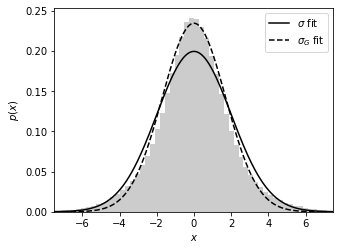

In [ ]:
# plot the results
fig, ax = plt.subplots(figsize=(5, 3.75))
ax.hist(x, 100, histtype='stepfilled', alpha=0.2,
        color='k', density=True)

# plot the fitting normal curves
x_sample = np.linspace(-15, 15, 1000)
ax.plot(x_sample, norm(mu_sample, sig_sample).pdf(x_sample),
        '-k', label='$\sigma$ fit')
ax.plot(x_sample, norm(med_sample, sigG_sample).pdf(x_sample),
        '--k', label='$\sigma_G$ fit')
ax.legend()

ax.set_xlim(-7.5, 7.5)
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')

## Gaussian Distribution with Gaussian Errors
The logarithm of the posterior probability density function for $\mu$ and $\sigma$, $L_p(\mu,\sigma)$, for a Gaussian distribution with **heteroscedastic Gaussian measurement errors** (sampled uniformly from the 0-3 interval), given by 

$$L_p = constant - \frac{1}{2}\sum^N_{i=1}(ln(\sigma^2+e_i^2)+\frac{(x_i-\mu)^2}{\sigma^2+e^2_i})$$


### 1. Define function
We define function based on Gaussian Distribution with Gaussian errors as described above, with input values $\mu = 1$ and $\sigma = 1$, and a randomly generated sample has 10 points.

In [ ]:
def gaussgauss_logL(xi, ei, mu, sigma):
    """Equation 5.63: gaussian likelihood with gaussian errors"""
    ndim = len(np.broadcast(sigma, mu).shape)

    xi = xi.reshape(xi.shape + tuple(ndim * [1]))
    ei = ei.reshape(ei.shape + tuple(ndim * [1]))

    s2_e2 = sigma ** 2 + ei ** 2
    return -0.5 * np.sum(np.log(s2_e2) + (xi - mu) ** 2 / s2_e2, 0)

# Define the grid and compute logL
np.random.seed(5)
mu_true = 1.
sigma_true = 1.
N = 10
ei = 3 * np.random.random(N)
xi = np.random.normal(mu_true, np.sqrt(sigma_true ** 2 + ei ** 2))

sigma = np.linspace(0.01, 5, 70)
mu = np.linspace(-3, 5, 70)

logL = gaussgauss_logL(xi, ei, mu, sigma[:, np.newaxis])
logL -= logL.max()

### 2. Generate Distribution diagram
Next, we draw a Gaussian distribution using the logarithm of the posterior probability density finction for  $\mu$ and $\sigma$, $L_p(\mu,\sigma)$ in the equation described above.  
  
Note that the posterior pdf is not symmetric with respect to the $\mu = 1$ line, and that the outermost contour, which encloses the region that contains 0.997 of the cumulative (integrated) posterior probability, allows solutions with $\sigma = 0$.

Text(0, 0.5, '$\\sigma$')

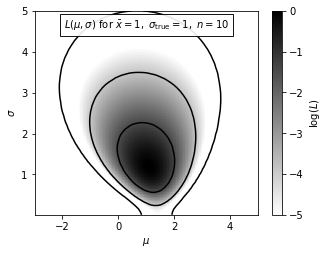

In [ ]:
# plot the results
fig = plt.figure(figsize=(5, 3.75))
plt.imshow(logL, origin='lower',
           extent=(mu[0], mu[-1], sigma[0], sigma[-1]),
           cmap=plt.cm.binary,
           aspect='auto')
plt.colorbar().set_label(r'$\log(L)$')
plt.clim(-5, 0)

plt.text(0.5, 0.93,
         (r'$L(\mu,\sigma)\ \mathrm{for}\ \bar{x}=1,\ '
          r'\sigma_{\rm true}=1,\ n=10$'),
         bbox=dict(ec='k', fc='w', alpha=0.9),
         ha='center', va='center', transform=plt.gca().transAxes)

plt.contour(mu, sigma, convert_to_stdev(logL),
            levels=(0.683, 0.955, 0.997),
            colors='k')

plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')

## Gaussian Distribution with Gaussian Errors
In this section we compare the **marginalized posterior pdfs** for $\mu$ (left) and $\sigma$ (right) for a Gaussian distribution with heteroscedastic Gaussian measurement errors (i.e., integrals over $\sigma$ and $\mu$ for the two-dimensional distribution), with the distributions of approximate estimates for $\mu$ and $\sigma$ (the median and given by 

$$\sigma_0^2=\zeta^2\sigma^2_G-e^2_{50}$$

, respectively) for 10,000 **bootstrap resamples** of the same data set. The true values of $\mu$ and $\sigma$ are indicated by the vertical dotted lines.

### 1. Define functions

In [ ]:
def gaussgauss_logL(xi, ei, mu, sigma):
    """Equation 5.63: gaussian likelihood with gaussian errors"""
    ndim = len(np.broadcast(sigma, mu).shape)

    xi = xi.reshape(xi.shape + tuple(ndim * [1]))
    ei = ei.reshape(ei.shape + tuple(ndim * [1]))

    s2_e2 = sigma ** 2 + ei ** 2
    return -0.5 * np.sum(np.log(s2_e2) + (xi - mu) ** 2 / s2_e2,
                         -1 - ndim)


def approximate_mu_sigma(xi, ei, axis=None):
    """Estimates of mu0 and sigma0 via equations 5.67 - 5.68"""
    if axis is not None:
        xi = np.rollaxis(xi, axis)
        ei = np.rollaxis(ei, axis)
        axis = 0

    mu_approx, sigmaG = median_sigmaG(xi, axis=axis)
    e50 = np.median(ei, axis=axis)
    var_twiddle = (sigmaG ** 2 + ei ** 2 - e50 ** 2)
    sigma_twiddle = np.sqrt(np.maximum(0, var_twiddle))

    med = np.median(sigma_twiddle, axis=axis)
    mu = np.mean(sigma_twiddle, axis=axis)

    zeta = np.ones_like(mu)
    zeta[mu != 0] = med[mu != 0] / mu[mu != 0]

    var_approx = zeta ** 2 * sigmaG ** 2 - e50 ** 2
    sigma_approx = np.sqrt(np.maximum(0, var_approx))

    return mu_approx, sigma_approx

### 2. Generate data
We generate data with hesteroscedatic Gaussian measurement errors. And we calculate 10,000 bootstrap resamples of the same data set.

In [ ]:
np.random.seed(5)
mu_true = 1.
sigma_true = 1.
N = 10
ei = 3 * np.random.random(N)
xi = np.random.normal(mu_true, np.sqrt(sigma_true ** 2 + ei ** 2))

sigma = np.linspace(0.001, 5, 70)
mu = np.linspace(-3, 5, 70)

logL = gaussgauss_logL(xi, ei, mu, sigma[:, np.newaxis])
logL -= logL.max()
L = np.exp(logL)

p_sigma = L.sum(1)
p_sigma /= (sigma[1] - sigma[0]) * p_sigma.sum()

p_mu = L.sum(0)
p_mu /= (mu[1] - mu[0]) * p_mu.sum()

#------------------------------------------------------------
# Compute bootstrap estimates
Nbootstraps = 10000
indices = np.random.randint(0, len(xi), (len(xi), 10000))

xi_boot = xi[indices]
ei_boot = ei[indices]

mu_boot, sigma_boot = approximate_mu_sigma(xi_boot, ei_boot, 0)

### 3. Plot and compare data
* The solid lines show marginalized posterior pdfs for $\mu$ (left) and $\sigma$ (right) for a Gaussian distribution with heteroscedastic Gaussian measurement errors (i.e., integrals over $\sigma$ and $\mu$ for the two-dimensional distribution shown in figure in the above section). 
* The dashed histograms show the distributions of approximate estimates for $\mu$ and $\sigma$ for bootstrap resamples of the same data set. 
* The true values of $\mu$ and $\sigma$ are indicated by the vertical dotted lines.

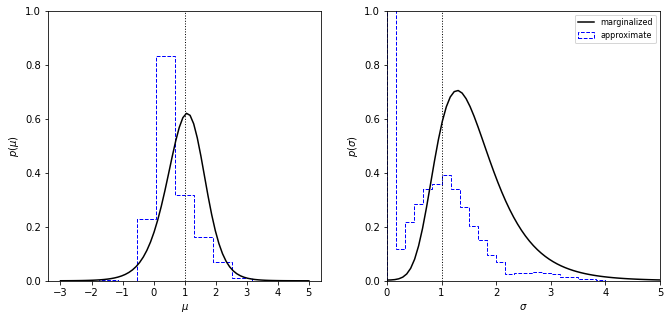

In [ ]:
# Plot data
fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.24,
                    bottom=0.15, top=0.9)

# first plot the histograms for mu
ax = fig.add_subplot(121)

# plot the marginalized distribution
ax.plot(mu, p_mu, '-k', label='marginalized')

# plot the bootstrap distribution
bins = np.linspace(-3, 5, 14)
ax.hist(mu_boot, bins, histtype='step', linestyle='dashed',
        color='b', density=True, label='approximate')

# plot vertical line: newer matplotlib versions can use ax.vlines(x)
ax.plot([mu_true, mu_true], [0, 1.0], ':k', lw=1)

ax.set_xlabel(r'$\mu$')
ax.set_ylabel(r'$p(\mu)$')

ax.set_ylim(0, 1.0)


# first plot the histograms for sigma
ax = fig.add_subplot(122)

# plot the marginalized distribution
ax.plot(sigma, p_sigma, '-k', label='marginalized')

# plot the bootstrap distribution
bins = np.linspace(0, 5, 31)
ax.hist(sigma_boot, bins, histtype='step', linestyle='dashed',
        color='b', density=True, label='approximate')

# plot vertical line: newer matplotlib versions can use ax.vlines(x)
ax.plot([sigma_true, sigma_true], [0, 1.0], ':k', lw=1)

ax.set_xlabel(r'$\sigma$')
ax.set_ylabel(r'$p(\sigma)$')
ax.legend(loc=1, prop=dict(size=8))

ax.set_xlim(0, 5.0)
ax.set_ylim(0, 1.0)

plt.show()